In [12]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from mlxtend.evaluate import bias_variance_decomp

In [14]:
df = pd.read_csv("datasets/data2.csv")

In [15]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
import io
buffer = io.StringIO()
df.info(buf=buffer)
s = buffer.getvalue()
with open("df_info.txt", "w", encoding="utf-8") as f:
    f.write(s)

In [17]:
drop_columns = ["Id", "Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df = df.drop(drop_columns, axis=1)
df = df.dropna()
print(df.shape)

(1094, 74)


In [18]:
y = df["SalePrice"]
df = df.drop("SalePrice",axis=1)

In [19]:
ss = StandardScaler()

y = ss.fit_transform(y.values.reshape(-1,1)).reshape(-1)

In [20]:
class autoLabelEncoder:
    def __init__(self) -> None:
        self.cat_encoders:dict = {}

    def fit(self, data:pd.DataFrame, categories:list[str]) -> None:
        for feat in categories:
            enc = LabelEncoder()
            self.cat_encoders[feat] = enc.fit(data.loc[data[feat].notna(), feat])

    def transform(self, data:pd.DataFrame, categories:list[str]) -> pd.DataFrame:
        for feat in categories:
            if(feat in data.columns):
                enc = self.cat_encoders[feat]
                data.loc[data[feat].notna(), feat] = (enc.transform(data.loc[data[feat].notna(), feat]))
                data[feat] = data[feat].astype(int)
        return data
    
    def get_encoder(self, category) -> LabelEncoder:
        return self.cat_encoders[category]


In [21]:
objs = df.select_dtypes(include='object')
le = autoLabelEncoder()
le.fit(df, objs)
df = le.transform(df, objs)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

In [22]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


# 1. Выделите обучающую и отложенную выборку. Рассмотрим индивидуальные деревья (4 балла)

### a. Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора.

In [30]:
scoring = {'mse': make_scorer(mean_squared_error)}

for depth in range(1,15):
    random_fr = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=1, bootstrap=False)
    print(str(depth) + ":", np.mean(cross_validate(random_fr,X_train,y_train,cv=5,scoring=scoring)["test_mse"]))

1: 0.5275140331615946
2: 0.3849155515622781
3: 0.2900847391741033
4: 0.2800668188511027
5: 0.2641860315684255
6: 0.2742971907102232
7: 0.2907434629934086
8: 0.26844629670279285
9: 0.2665218888598525
10: 0.23799265340110462
11: 0.2441969232973571
12: 0.2889559479781612
13: 0.27812080632188113
14: 0.2816059802610082


[]

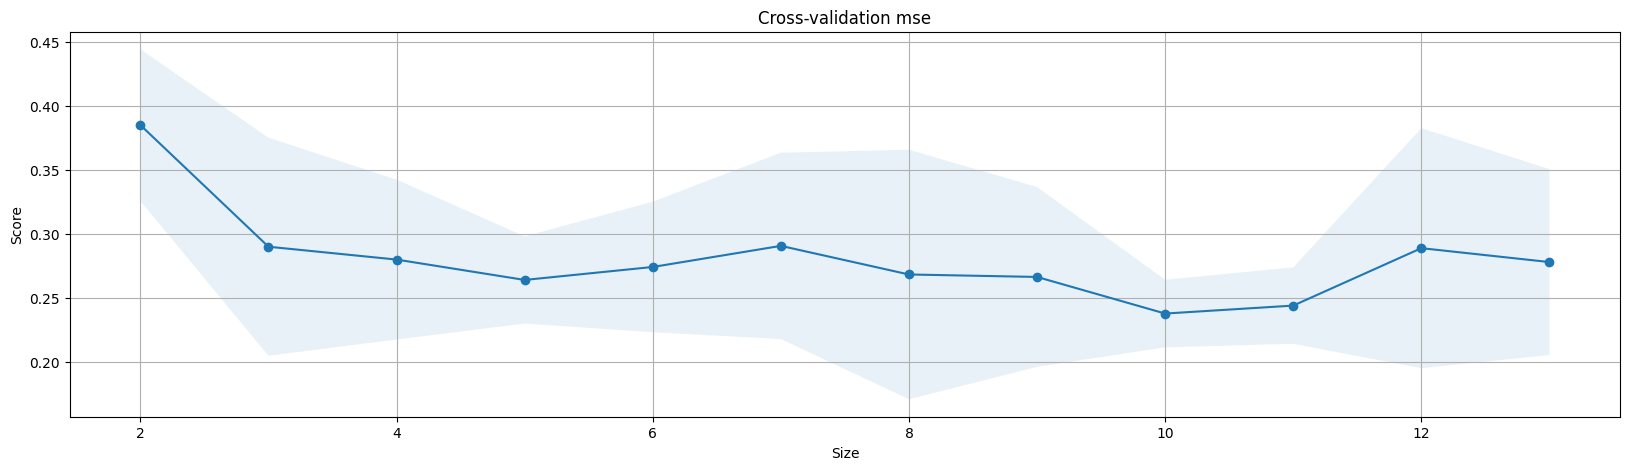

In [31]:
random_fr = RandomForestRegressor(n_estimators=1, random_state=1, bootstrap=False)

max_depth_range = list(range(2, 14, 1))
scoring = make_scorer(mean_squared_error)

train_scores, test_scores = validation_curve(
        random_fr,
        X_train, y_train,
        param_name="max_depth",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)


def plot_validation_curve(X, y, err, axes = None, x_lab = "", y_lab = "", title = ""):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))
    
    axes.grid()
    axes.plot(X, y, "o-")
    axes.fill_between(
        X,
        y - err,
        y + err,
        alpha=0.1,
    )
    axes.set_xlabel(x_lab)
    axes.set_ylabel(y_lab)
    axes.set_title(title)

    return plt

plot_validation_curve(max_depth_range, np.mean(test_scores,axis=1), np.std(test_scores, axis=1), x_lab="Size", y_lab="Score", title="Cross-validation mse").plot()

### b. Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.

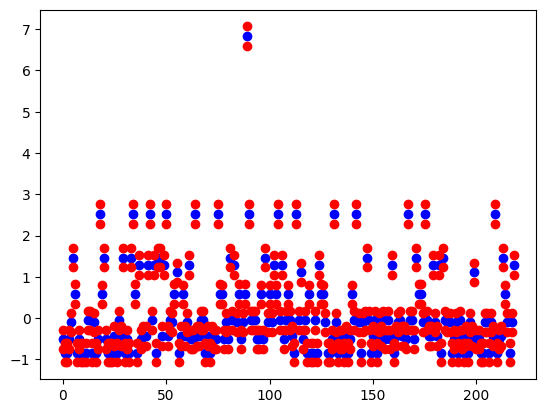

In [37]:
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False)
rr.fit(X_train,y_train)
pred = rr.predict(X_test)
err = mean_squared_error(pred,y_test)

a = np.arange(0,len(pred),1)
plt.plot(a, pred,'bo')
plt.plot(a, pred-err,'ro')
plt.plot(a, pred+err,'ro',)

In [45]:
showing = []
for i in range(1,26,5):
    rr = RandomForestRegressor(n_estimators=i, max_depth=6, bootstrap=False, random_state=1)
    rr.fit(X_train,y_train)
    showing.append(mean_squared_error(rr.predict(X_test),y_test))

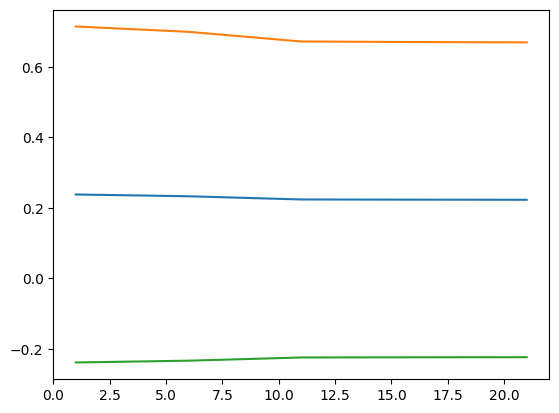

In [46]:
a = np.arange(1,26,5)
plt.plot(a,  showing)
plt.plot(a, [2*i + i for i in showing])
plt.plot(a, [-2*i + i for i in showing])

[]

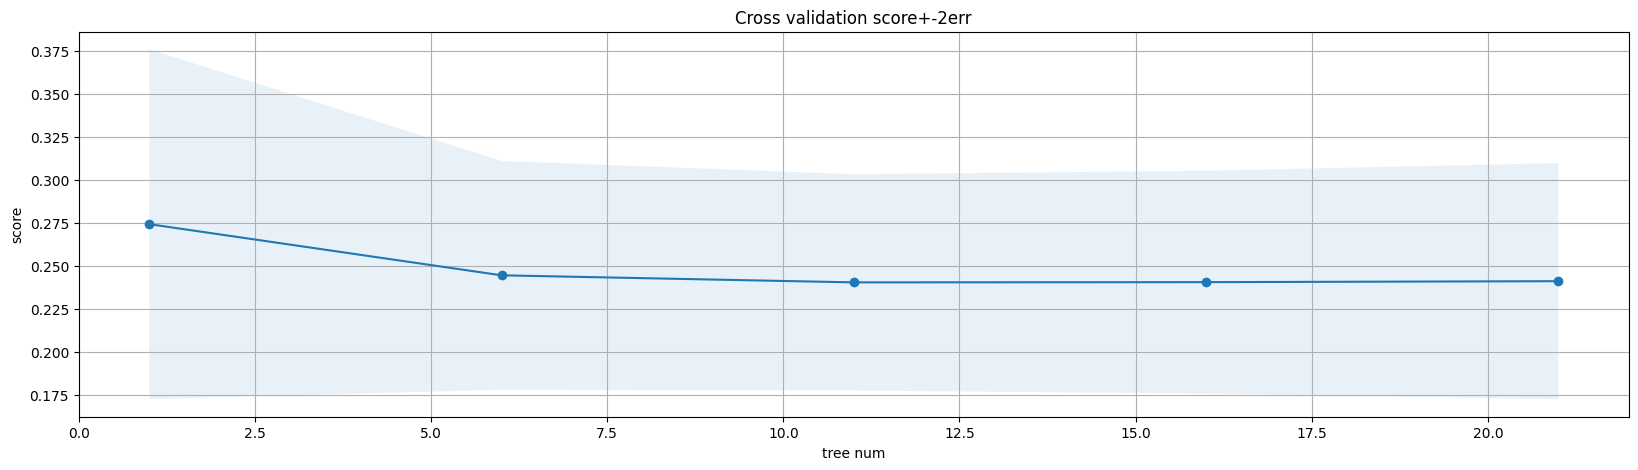

In [43]:
random_fr = RandomForestRegressor(max_depth=6, bootstrap=False, random_state=1)

max_depth_range = list(range(1, 26, 5))
scoring = make_scorer(mean_squared_error)
train_scores, test_scores = validation_curve(
        random_fr,
        X_train, y_train,
        param_name="n_estimators",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)

err2 = 2*np.std(test_scores, axis=1)

plot_validation_curve(max_depth_range, np.mean(test_scores,axis=1), err2, title="Cross validation score+-2err" , x_lab = "tree num", y_lab = "score").plot()

### d. Визуализируйте предсказания на отложенной выборке. Можно ли получить интервальные предсказания и для нее?

model.predict(X_test) +- mean_squared_error(X_train, y_train)

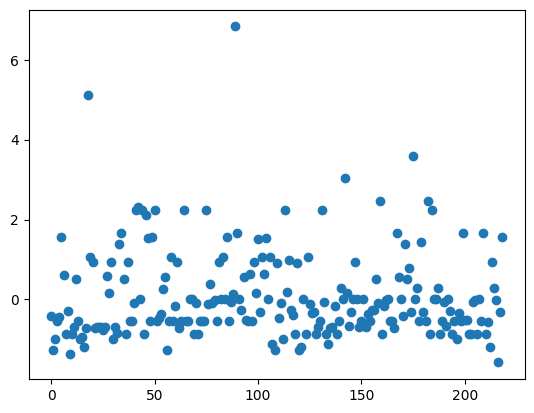

In [47]:
rr = RandomForestRegressor(n_estimators=1, max_depth=9, bootstrap=False)
pred = rr.fit(X_train,y_train).predict(X_test)
plt.plot(np.arange(0,len(pred),1),pred,'o')

# 2. Перейдите к беггингу. C помощью кросс-валидации постройте и обучите несколько отдельных деревьев (4 балла).

### a. Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [48]:
errors = []
varianses = []

tree = DecisionTreeRegressor(min_samples_leaf=1, max_depth=5, random_state=1)

for i in range(20):
    cv = cross_validate(tree, X_train, y_train, cv=5, scoring="r2")
    errors.append(np.mean(cv["test_score"]))
    varianses.append(np.var(cv["test_score"]))

0.7199886885535636
0.001164909848356083


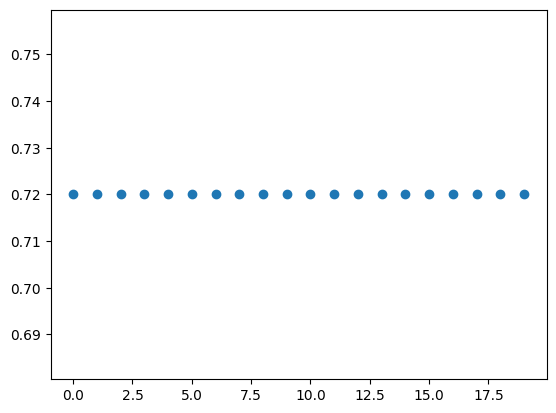

In [49]:
print(np.mean(errors))
print(np.mean(varianses))
plt.plot(np.arange(0,len(errors),1), errors, 'o')

### b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [50]:
for depth in range(1, 6):
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=1)
    
    br = BaggingRegressor(tree, n_estimators=5, random_state=1)
    
    cv = cross_validate(br, X_train, y_train, cv=10, scoring="r2")

    print("Depth:", depth)
    print("Mean:", np.mean(cv["test_score"]))
    print("Var:", np.var(cv["test_score"]))

Depth: 1
Mean: 0.46760624284779
Var: 0.009858993291625545
Depth: 2
Mean: 0.6498084628563555
Var: 0.004617606678218397
Depth: 3
Mean: 0.709746557742735
Var: 0.007420255249040088
Depth: 4
Mean: 0.7725994379813662
Var: 0.0044707747118056754
Depth: 5
Mean: 0.7921596798227406
Var: 0.002138964171717851


### c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)

In [51]:
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)

arr = []

for i in range(1,501,50):
    model = BaggingRegressor(tree, n_estimators=i)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    _, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=1)
    arr.append((i, bias, var))

[]

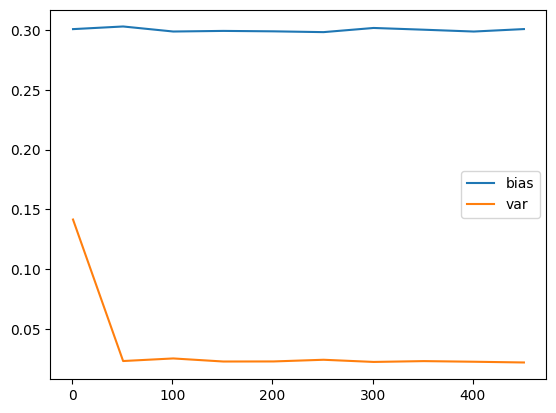

In [52]:
sns.lineplot(x=[i[0] for i in arr], y=[i[1] for i in arr],label="bias")
sns.lineplot(x=[i[0] for i in arr], y=[i[2] for i in arr],label="var")
plt.plot()